In [2]:
import pandas as pd 
import seaborn as sns
import os
import numpy as np
import openpyxl
pd.set_option('display.max_columns', None)

In [3]:
# Defining functions

def cleanData(df):
    df.columns = df.columns.str.replace('/','_').str.replace(" ", "_").str.replace('-', '_').str.replace('%','pct').str.replace(' / ','_').str.replace(' - ', '_')
    df.columns = df.columns.str.replace('__','_').str.replace('___','_').str.replace('__','_')
    #strip and adjust column names 
    #df = df.iloc[2:].drop(columns= np.nan).astype('float')
    return df


def DF_fromTabs_Excel(path):

    df_list = []
    df_names = []
    
    from openpyxl import load_workbook
    wb = load_workbook(path, read_only=True, keep_links=False)
    lst = wb.sheetnames

    for tab in lst:
        name = tab.replace(' ','_')
        df = pd.read_excel(path, sheet_name=tab)
        df = cleanData(df)
        df_list.append(df)
        df_names.append(name)
        df_dict = {k:v for k,v in zip(df_names, df_list)}
    print(f'Access through the following keys: {df_names}')
    return df_dict 

In [4]:
path = 'Common Data Warehouse.xlsx'
df_dict = DF_fromTabs_Excel(path)

Access through the following keys: ['Customer', 'Instrument', 'Financial', 'GL', 'Group_GL']


In [5]:
df_dict['Financial'] = df_dict['Financial'].rename(columns ={'Agmt_ID':'Agreement_ID', 'GL_Acct_ID':'GL_Account_ID', 'Cust_ID':'Customer_ID'})
df_dict['GL'] = df_dict['GL'].rename(columns= {'Group_GL_Acct_ID':'Group_GL_Account_ID'})
df_dict['Customer'] = df_dict['Customer'].rename(columns = {'Country':'Country_Customer'})
df_dict['Instrument'] = df_dict['Instrument'].rename(columns = {'Country':'Country_Instrument'})

In [6]:
df_Q1 = df_dict['Financial']
df_Q1 = pd.merge(df_Q1, df_dict['Customer'][['Sector_Name','Customer_ID']], how = 'left', on = 'Customer_ID')
df_Q1 = pd.merge(df_Q1, df_dict['GL'][['GL_Account_ID','GL_Account_Name']], how = 'left', on = 'GL_Account_ID')
df_Q1.head()

,Agreement_ID,GL_Account_ID,Source,Customer_ID,Amount,Sector_Name,GL_Account_Name
0,1000162418540,1000000008710,229|ADJ,1000007793706,0.00,Non financial corporations,Assets
1,1000376865946,1000000013691,229,1000009653088,-5198.52,Non financial corporations,Assets
2,1000205191664,1000000008710,229|ADJ,1000044609208,0.00,Non financial corporations,Assets
3,1000329416423,1000000008710,229|ADJ,1000009657652,0.00,Non financial corporations,Assets
4,1000239743539,1000000008710,229|ADJ,1000007699415,0.00,NaN,Assets


In [53]:
df_Q1_cat = df_Q1.copy()

In [54]:
df_Q1_cat['Source'] = df_Q1_cat['Source'].astype('category').cat.codes
df_Q1_cat['Sector_Name'] = df_Q1_cat['Sector_Name'].astype('category').cat.codes
df_Q1_cat['GL_Account_Name'] = df_Q1_cat['GL_Account_Name'].astype('category').cat.codes

In [55]:
df_Q1

,Agreement_ID,GL_Account_ID,Source,Customer_ID,Amount,Sector_Name,GL_Account_Name
0,1000162418540,1000000008710,229|ADJ,1000007793706,0.00,Non financial corporations,Assets
1,1000376865946,1000000013691,229,1000009653088,-5198.52,Non financial corporations,Assets
2,1000205191664,1000000008710,229|ADJ,1000044609208,0.00,Non financial corporations,Assets
3,1000329416423,1000000008710,229|ADJ,1000009657652,0.00,Non financial corporations,Assets
4,1000239743539,1000000008710,229|ADJ,1000007699415,0.00,NaN,Assets
...,...,...,...,...,...,...,...
39351,1000395429933,1000000013691,229,1000020757355,-260.27,Households,Assets
39352,1000329416652,1000000008710,229|ADJ,1000009664986,0.00,Non financial corporations,Assets
39353,1000233274452,1000000009076,229|ADJ,1000009074607,-55.03,NaN,Assets
39354,1000169428888,1000000008710,229|ADJ,1000009135343,0.00,Non financial corporations,Assets


In [56]:
data_K = df_Q1_cat[['Source','Amount','Sector_Name','GL_Account_Name']]

/home/siathor/Documents/DS_Bootcamp/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/siathor/Documents/DS_Bootcamp/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/siathor/Documents/DS_Bootcamp/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/siathor/Documents/DS_Bootcamp/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` expl

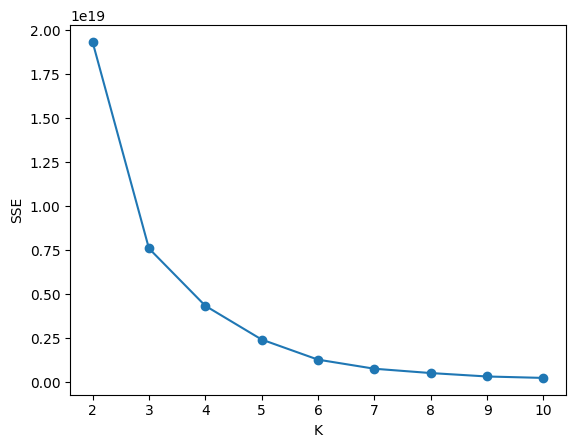

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def find_optimal_clusters(data_K, max_k=10):
    iters = range(2, max_k+1, 1)
    sse = []
    for k in iters:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data_K)
        sse.append(kmeans.inertia_)
    plt.plot(iters, sse, marker='o')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.show()

# find optimal number of clusters using elbow method
find_optimal_clusters(data_K)

/home/siathor/Documents/DS_Bootcamp/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


InvalidIndexError: (array([    0,     1,     2, ..., 39353, 39354, 39355]),)

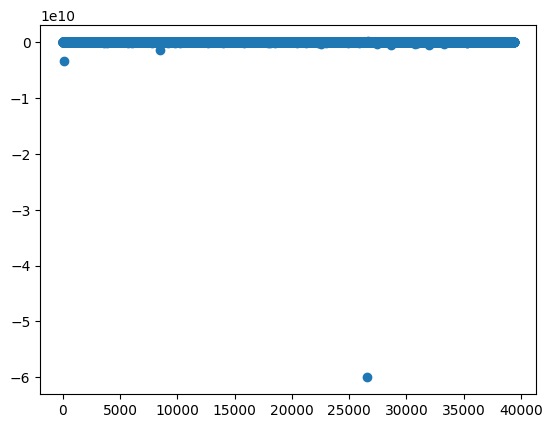

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def detect_outliers(data_K, k=5):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_K)
    distances = kmeans.transform(data_K)
    sorted_distances = np.sort(np.min(distances, axis=1))
    threshold = sorted_distances[int(0.05 * len(data_K))] # keep the top 5% data_K points
    outliers = np.where(np.min(distances, axis=1) > threshold)
    return outliers


# detect outliers
outlier_indices = detect_outliers(data_K)

# plot data_K with outliers highlighted
plt.scatter(range(len(data_K)), np.sum(data_K, axis=1))
plt.scatter(outlier_indices, np.sum(data_K[outlier_indices], axis=1), color='red', marker='x')
plt.show()

In [33]:
list(outlier_indices)[0].shape

(37388,)

In [46]:
df_Q1.iloc[list(outlier_indices)[0]]

,Agreement_ID,GL_Account_ID,Source,Customer_ID,Amount,Sector_Name,GL_Account_Name
0,1000162418540,1000000008710,1,1000007793706,0.00,4,0
1,1000376865946,1000000013691,0,1000009653088,-5198.52,4,0
2,1000205191664,1000000008710,1,1000044609208,0.00,4,0
3,1000329416423,1000000008710,1,1000009657652,0.00,4,0
4,1000239743539,1000000008710,1,1000007699415,0.00,-1,0
...,...,...,...,...,...,...,...
39351,1000395429933,1000000013691,0,1000020757355,-260.27,3,0
39352,1000329416652,1000000008710,1,1000009664986,0.00,4,0
39353,1000233274452,1000000009076,1,1000009074607,-55.03,-1,0
39354,1000169428888,1000000008710,1,1000009135343,0.00,4,0


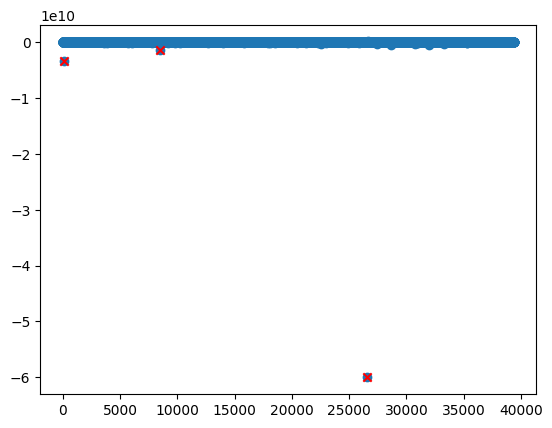

In [61]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

data_Z = df_Q1['Amount']

def detect_outliers(data_Z):
    z = np.abs(stats.zscore(data_Z))
    threshold = 3
    outliers = np.where(z > threshold)
    return outliers


# detect outliers
outlier_indices = detect_outliers(data_Z)

outlier_indices = list(outlier_indices)[0]

# plot data_Z with outliers highlighted
plt.scatter(range(len(data_Z)), data_Z)
plt.scatter(outlier_indices, data_Z[outlier_indices], color='red', marker='x')
plt.show()


In [67]:
data_Z[outlier_indices]

111     -3.394932e+09
8480    -1.453529e+09
26569   -6.000000e+10
Name: Amount, dtype: float64

In [85]:
import plotly.graph_objects as go

fig = go.Figure()



fig.add_trace(go.Scatter(

    x=list(range(len(data_Z))), 
    y=data_Z,
    marker_color = '#0000A0',
    mode = 'markers',
    marker = dict(size = 8),
    #text=grouped['percentage'].apply(lambda x: '{:.3f}%'.format(x)),
    name = 'Z < 3' 
    #color_continuous_scale='Blues', 
    ))


fig.add_trace(go.Scatter(

    x=outlier_indices, 
    y=data_Z[outlier_indices],
    marker_color = 'red',
    mode = 'markers',
    marker = dict(size = 15),
    #text=grouped['percentage'].apply(lambda x: '{:.3f}%'.format(x)),
    name = 'Z > 3' 
    #color_continuous_scale='Blues', 
    ))

#fig.update_traces( textposition='outside'),

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(title_text="Transactoin Amounts",  width=2000, height=1000, font=dict(size=18), xaxis_tickangle=0, paper_bgcolor='white', plot_bgcolor = 'white')
fig.show()




In [59]:
df_Q1.iloc[list(outlier_indices)]

,Agreement_ID,GL_Account_ID,Source,Customer_ID,Amount,Sector_Name,GL_Account_Name
111,1000379280791,1000000008710,229,1000004430504,-3.394932e+09,Credit institutions,Assets
8480,1000174226255,1000000008590,229,1000004430504,-1.453529e+09,Credit institutions,Off-balance-sheet items
26569,1000112687365,1000000008590,229,1000029025316,-6.000000e+10,Credit institutions,Off-balance-sheet items
